# **Recommendation System Model**

## *Imports*

In [6]:
!pip install pandas
!pip install numpy
!pip install statistics
!pip install sklearn
!pip install scipy
!pip install seaborn
!pip install matplotlib
!pip install tqdm
!pip install surprise
!pip install lightfm
!pip install gensim
!pip install pickle
!pip install ./scikit-learn

In [46]:
import pandas as pd
import numpy as np
import statistics

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pickle
import gensim

from typing import List

from sklearn.neighbors import BallTree
from sklearn.decomposition import NMF, MiniBatchNMF
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer

from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.linalg import svds
from surprise import Dataset, Reader

from gensim.models import Word2Vec, KeyedVectors

from smart_substitution_model import df_recipe

## **Data Set: User Interactions**

### Data Cleaning

The provided dataset contains a split for the test, train, and validation sets. Data contains dated user interactions with recipes found on food.com.

In [47]:
test = pd.read_csv('data/interactions_test.csv')
train = pd.read_csv('data/interactions_train.csv')
validation = pd.read_csv('data/interactions_validation.csv')

In [48]:
dataframes = [test, train, validation]

for df in dataframes:
    df.insert(0, 'u', df.pop('u'))
    df.insert(1, 'i', df.pop('i'))
    df.drop(['user_id', 'date', 'recipe_id'], axis=1, inplace=True)

In [49]:
train = train.rename(columns={'u': 'user_id'})
train = train.rename(columns={'i': 'recipe_id'})

test = test.rename(columns={'u': 'user_id'})
test = test.rename(columns={'i': 'recipe_id'})

validation = validation.rename(columns={'u': 'user_id'})
validation = validation.rename(columns={'i': 'recipe_id'})

In [50]:
combined = pd.concat([test, train, validation], axis=0)

### Trim Data

In order to reduce sparseness of the rating matrix, users with less than a specified amount of reviews was removed from the dataset. New train, test, validation datasets were created

In [51]:
user_counts = combined['user_id'].value_counts().sort_index()
bad_users = []

for user, val in user_counts.items():
  if val < 500:
    bad_users.append(user)
  
print(str(len(bad_users)) + " --> new dataset: " + str(25075 - len(bad_users)))

24881 --> new dataset: 194


In [52]:
trimmed = combined[~combined['user_id'].isin(bad_users)].dropna()
print(trimmed.shape)

(211929, 3)


In [53]:
train, test = train_test_split(trimmed, test_size=0.15, random_state=36)
train, validation = train_test_split(train, test_size=0.15, random_state=36)

print('total size: ' + str(train.shape[0] + test.shape[0] + validation.shape[0]))
print('train: ' + str(train.shape))
print('test: ' + str(test.shape))
print('validation: ' + str(validation.shape))

total size: 211929
train: (153118, 3)
test: (31790, 3)
validation: (27021, 3)


### Create Rating Matricies

In [54]:
# train
rating_matrix = pd.pivot_table(train, values='rating', index='user_id', columns='recipe_id')

In [55]:
# validate
rating_matrix_v = pd.pivot_table(validation, values='rating', index='user_id', columns='recipe_id')

In [56]:
training_cols = set(rating_matrix.columns)
validation_cols = set(rating_matrix_v.columns)
common = training_cols.intersection(validation_cols)
common = list(common)

In [57]:
rating_matrix = rating_matrix.reindex(columns=common, fill_value=0)
rating_matrix_v = rating_matrix_v.reindex(columns=common, fill_value=0)

In [58]:
rating_matrix = rating_matrix.reindex(sorted(rating_matrix.columns), axis=1)
rating_matrix_v = rating_matrix_v.reindex(sorted(rating_matrix_v.columns), axis=1)

In [59]:
rating_matrix_array = rating_matrix.values
rating_matrix_array_v = rating_matrix_v.values

### Visualize Rating Matricies

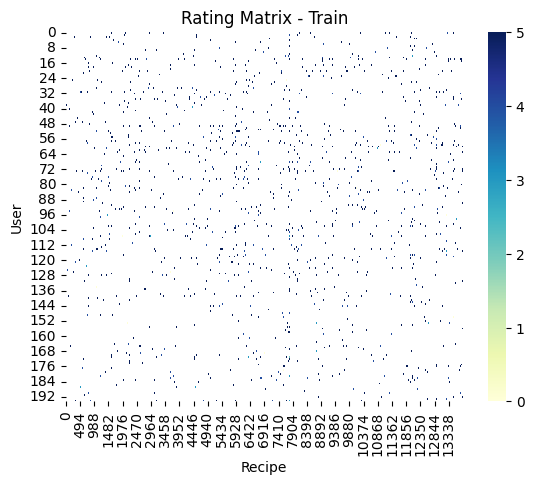

In [60]:
sns.heatmap(rating_matrix_array[:250], cmap='YlGnBu')
plt.title('Rating Matrix - Train')
plt.xlabel('Recipe')
plt.ylabel('User')
plt.show()

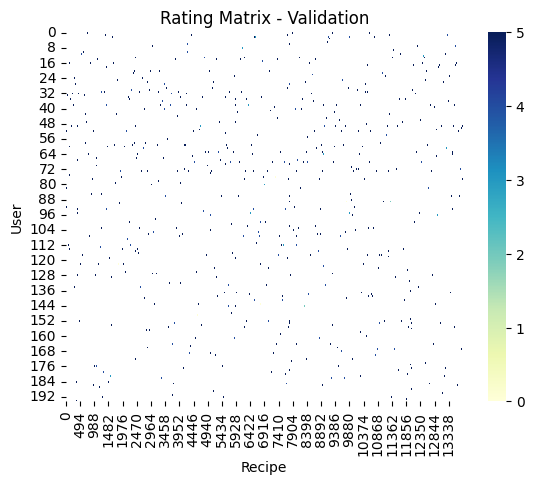

In [61]:
sns.heatmap(rating_matrix_array_v[:250], cmap='YlGnBu')
plt.title('Rating Matrix - Validation')
plt.xlabel('Recipe')
plt.ylabel('User')
plt.show()

## Create Model

In [62]:
def create_model(n_components=20, alpha_W=0.0, alpha_H='same', l1_ratio=0.0):
    init = 'random'
    solver = 'mu'
    beta_loss = 'frobenius'
    tol = 1e-4
    max_iter = 1000 
    random_state = 10
    verbose = 0
    shuffle = False
    model = NMF(n_components=n_components, init=init, solver=solver, beta_loss=beta_loss, tol=tol, max_iter=max_iter, random_state=random_state, alpha_W=alpha_W, alpha_H=alpha_H, l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)
    
    return model

In [63]:
def run_model(model):
    user_features = model.fit_transform(rating_matrix_array)
    recipe_features = model.components_
    val_set_transformed = model.transform(rating_matrix_array_v)
    predicted_val_ratings = np.dot(val_set_transformed, recipe_features)
    rating_matrix_v_masked = np.invert(np.isnan(rating_matrix_array_v)).astype(int)
    rmse = np.sqrt(mean_squared_error(rating_matrix_v_masked, predicted_val_ratings))
    
    return rmse

In [64]:
# default model
n_components = 2
init = 'random'
solver = 'mu'
beta_loss = 'frobenius'
tol = 1e-4
max_iter = 1000 
random_state = 10 
alpha_W = 0.0 
alpha_H = 'same'
l1_ratio = 0.0
verbose = 0
shuffle = False

model = NMF(n_components=n_components, init=init, solver=solver, beta_loss=beta_loss, tol=tol, max_iter=max_iter, random_state=random_state, alpha_W=alpha_W, alpha_H=alpha_H, l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)

In [65]:
# features
user_features = model.fit_transform(rating_matrix_array)
recipe_features = model.components_

In [66]:
# transform
val_set_transformed = model.transform(rating_matrix_array_v)

In [67]:
# predict
predicted_val_ratings = np.dot(val_set_transformed, recipe_features)

In [68]:
# make mask
rating_matrix_v_masked = np.invert(np.isnan(rating_matrix_array_v)).astype(int)

Calculated RMSE Value: 5.484568691663197


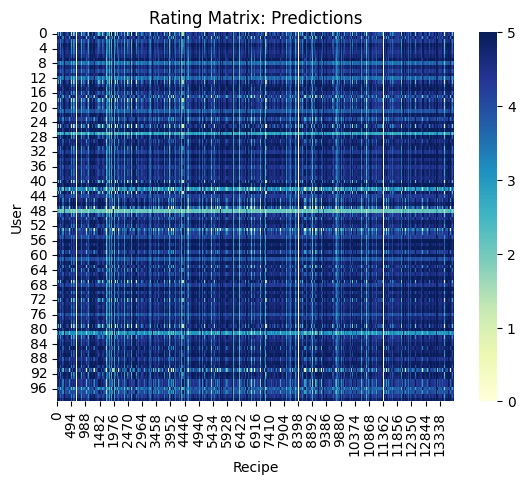

In [69]:
# visualize
sns.heatmap(predicted_val_ratings[:100], cmap='YlGnBu', vmin=0, vmax=5)
plt.title('Rating Matrix: Predictions')
plt.xlabel('Recipe')
plt.ylabel('User')
plt.show()

### Determination of Optimal Parameters + Evaluation

Here, GridSearchCV was employed, as well as observing the effect of fitting the model to different parameters over several epochs. Variables experimented with were:
- n_components
- alpha_H
- alpha_W
- l1_ratio

In [ ]:
# evaluate
rmse = np.sqrt(mean_squared_error(rating_matrix_v_masked, predicted_val_ratings))
print('Calculated RMSE Value:', rmse)

In [ ]:
# changing n_components
rmse_list = []
reconstructed_errors = []

for num_comp in range(1,30):
    model = create_model(n_components=num_comp)
    rmse_val = run_model(model)
    rmse_list.append(rmse_val)
    reconstructed_errors.append(model.reconstruction_err_)
    print('finished: #' + str(num_comp))
    
    
plt.plot(rmse_list)
plt.xlabel('#')
plt.ylabel('rmse')
plt.show()

plt.plot(reconstructed_errors)
plt.xlabel('#')
plt.ylabel('reconst')
plt.show()

In [ ]:
# changing alpha_H
rmse_list = []
reconstructed_errors = []

new_alpha_H = 0.001/40
for i in range(25):
    new_alpha_H *= 40 
    model = create_model(alpha_H=new_alpha_H)
    rmse_val = run_model(model)
    rmse_list.append(rmse_val)
    reconstructed_errors.append(model.reconstruction_err_)
    print('finished: #' + str(i))
    
    
plt.plot(rmse_list)
plt.xlabel('#')
plt.ylabel('rmse')
plt.show()

plt.plot(reconstructed_errors)
plt.xlabel('#')
plt.ylabel('reconst')
plt.show()

In [ ]:
# changing alpha_W
rmse_list = []
reconstructed_errors = []

new_alpha_W = 0.001/40
for i in range(25):
    new_alpha_W *= 40 
    model = create_model(alpha_W=new_alpha_W)
    rmse_val = run_model(model)
    rmse_list.append(rmse_val)
    reconstructed_errors.append(model.reconstruction_err_)
    print('finished: #' + str(i))
    
    
plt.plot(rmse_list)
plt.xlabel('#')
plt.ylabel('rmse')
plt.show()

plt.plot(reconstructed_errors)
plt.xlabel('#')
plt.ylabel('reconst')
plt.show()

In [ ]:
# changing l1_ratio
rmse_list = []
reconstructed_errors = []

new_l1_ratio = -0.05
for i in range(20):
    new_l1_ratio += 0.05 
    model = create_model(l1_ratio=new_l1_ratio)
    rmse_val = run_model(model)
    rmse_list.append(rmse_val)
    reconstructed_errors.append(model.reconstruction_err_)
    print('finished: #' + str(i))
    
    
plt.plot(rmse_list)
plt.xlabel('#')
plt.ylabel('rmse')
plt.show()

plt.plot(reconstructed_errors)
plt.xlabel('#')
plt.ylabel('reconst')
plt.show()

In [36]:
# GridSearchCV
model_params = {'n_components': [15,16,17,18,19,20,21,22,23,24,25],
                'beta_loss': ['frobenius', 'kullback-leibler'],
                'alpha_W': [0.001, 0.01, 0.1, 1],
                'alpha_H': [0.001, 0.01, 0.1, 1],
                'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

n_components = 2
init = 'random'
solver = 'mu'
max_iter = 1000 
random_state = 10
nmf_model = NMF(init=init, solver=solver, beta_loss=beta_loss, max_iter=max_iter, random_state=random_state)

In [37]:
grid_search = GridSearchCV(nmf_model, model_params, scoring='neg_mean_squared_error')

In [38]:
grid_search.fit(rating_matrix_v_masked, predicted_val_ratings)

print(grid_search.best_estimator_)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

/home/sfarnum/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:825: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sfarnum/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 814, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/sfarnum/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 235, in __call__
    return self._score(
  File "/home/sfarnum/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 277, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/sfarnum/env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'NMF' object has no attribute 'predict'

  warnings.warn(
/home/sfarnum/env/lib/python3.9/site-packages/sklearn/model_selection/_va

KeyboardInterrupt: 

## Combined Model

Following data cleaning and finding optimal parameters for the NMF model, the recommendation system needs to be merged with the smart substitution algorithm. We can use `from recipe_similarity import df_recipe` to retrieve the dataframe with similarity scores.

In [70]:
predict_rating_matrix = pd.DataFrame(data=predicted_val_ratings, index=rating_matrix.index, columns=rating_matrix.columns)
final_predictions_df = predict_rating_matrix.stack().reset_index()
final_predictions_df.columns = ['user_id', 'recipe_id', 'rating']
final_predictions_df.head()

,user_id,recipe_id,rating
0,3,19,4.078455
1,3,33,4.545572
2,3,51,2.362971
3,3,98,5.871482
4,3,99,3.940313


In [71]:
demo_id = int(input('Input a number for a specified user: '))
df_user = final_predictions_df[final_predictions_df['user_id'] == demo_id][['recipe_id', 'rating']]
df_user.head()

Input a number for a specified user: 3


,recipe_id,rating
0,19,4.078455
1,33,4.545572
2,51,2.362971
3,98,5.871482
4,99,3.940313


In [72]:
df_recipe = df_recipe.reset_index()
df_recipe = df_recipe.rename(columns={'index':'recipe_id'})
df_recipe.head()

,recipe_id,name,ids,score
0,0,white bean green chile pepper soup,"[1257, 2127, 2778, 3217, 3384, 3502, 5006, 665...",0.021922
1,1,devilicious cookie cake delights,"[2499, 5382, 7557, 912]",0.004079
2,2,baked potato toppings,"[1168, 1699, 2982, 3440, 3597, 4623, 4836, 518...",0.041311
3,3,kfc honey bbq strips,"[1304, 2683, 3217, 3532, 3698, 3723, 4053, 443...",0.150946
4,4,lamb stew with tomatoes chickpeas and spices,"[1257, 1313, 2683, 2856, 3203, 3486, 3497, 350...",0.000000


In [73]:
final_rec = pd.merge(df_user, df_recipe, on='recipe_id')
final_rec = final_rec.drop(columns=['ids'])
final_rec.head(10)

,recipe_id,rating,name,score
0,19,4.078455,honey glazed baby carrots,0.019628
1,33,4.545572,scallops with garlic bread crumbs weight watchers,0.010293
2,51,2.362971,fran s easy shortbread bars,0.000000
3,98,5.871482,oats and peanut butter giant cookies,0.000000
4,99,3.940313,creole tomato soup low fat,0.000000
5,109,4.178210,indian style green beans,0.000000
6,112,4.259165,world s easiest lemonade ice cream pie,0.400288
7,113,6.857846,bigos from out of this kitchen,0.141401
8,137,4.222405,a very interesting smoked salmon sandwich,0.302392
9,145,4.431960,tomato and mushroom omelette,0.012304


In [74]:
final_rec["rating"] = final_rec["rating"] / 5
final_rec["average"] = (final_rec["rating"] + final_rec["score"]) / 2

## Final Top 10 Ratings

The two models were combined by using the user predicted ratings from the NMF model and the similarity scores from the smart substitution model. We can normalize the rating to get a number from 0-1, then average the result of the rating and the similarity score to obtain a cumulative score. We can then use this number to determine what the top recommended recipes are based on the inputted user.

In [76]:
final_rec = final_rec.sort_values(by="average", ascending=False)
final_rec.head(10)

,recipe_id,rating,name,score,average
7495,96012,66.966902,microwave chocolate oatmeal cake,0.000000,33.483451
5464,69500,24.266274,roasted corn on the cob,0.110004,12.188139
6593,83925,21.227976,creamy swiss spinach bake,0.015100,10.621538
319,3936,19.660732,summer potatoes with spring onions,0.000000,9.830366
8061,103336,17.455551,jenny gentile s pizza dough,0.000000,8.727776
8159,104650,17.411592,spinach phyllo casserole,0.000000,8.705796
9464,121458,13.119285,richest and easiest butterscotch cookies,0.041029,6.580157
13569,174509,11.120571,far breton aux pommes apple pie,0.000000,5.560286
6968,89209,10.087926,kfc chicken secret spices,0.190404,5.139165
2227,28983,9.868576,quick mac beans,0.060828,4.964702
